In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
Set1 = mpl.colormaps['Set1']
Pastel1 = mpl.colormaps['Pastel1']
mcolor = Set1(0.0)
hcolor = Set1(1.0 / 9)
mcolor_light = Pastel1(0.0)
hcolor_light = Pastel1(1.0 / 9)

In [3]:
%%capture
!rm -rf x86_64
!nrnivmodl ../mechanisms

In [4]:
import efel
from neuron import h
h.load_file("stdrun.hoc");

In [5]:
from glob import glob
cellhocs = sorted(glob('Cell_*.hoc'))
cellhocs

['Cell_0.hoc',
 'Cell_1.hoc',
 'Cell_2.hoc',
 'Cell_4.hoc',
 'Cell_5.hoc',
 'Cell_8.hoc']

In [6]:
simtime = 1400
stim_start = 400
stim_end = simtime

In [7]:
amps = np.arange(0.010, 0.026, 0.002)

In [8]:
def breadth(sec):
    return len(sec.subtree())

def is_terminal(sec):
    return breadth(sec) == 1

def get_terminals(sec):
    return [s for s in sec.subtree() if is_terminal(s)]

In [9]:
def run_sweep(amp, cell):
    h.v_init = -91.5
    h.celsius = 35
    h.tstop = simtime
    
    stimuli = []
    dend_tips = sorted([sec for sec in get_terminals(cell.soma[0]) if 'dend' in sec.name()])
    for tip in dend_tips:
        stim = h.IClamp(tip(1.0))
        stim.amp = amp
        stim.delay = stim_start
        stim.dur = stim_end - stim_start
        stimuli.append(stim)
    
    time = h.Vector()
    volt = h.Vector()
    time.record(h._ref_t)
    volt.record(cell.soma[0](0.5)._ref_v)
    
    cvode = h.CVode()
    cvode.active(1)
    h.dt = 0.025
    h.run()

    return time, volt

In [10]:
def run_model(hoc, amps):
    h.load_file(hoc)
    name = hoc.split('.')[0]
    cmd = 'h.%s("../morphology/")' % name  # default morphology
    cell = eval(cmd)
    
    sweeps = []
    for amp in amps:
        time, volt = run_sweep(amp, cell)
        sweeps.append({'time': list(time), 'volt': list(volt), 'amp': amp})
        
    return sweeps

In [11]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

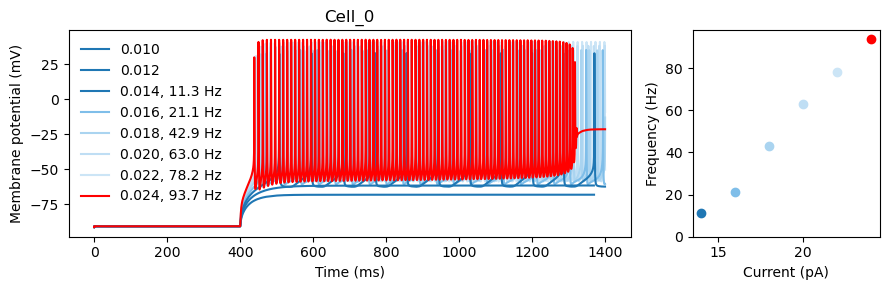

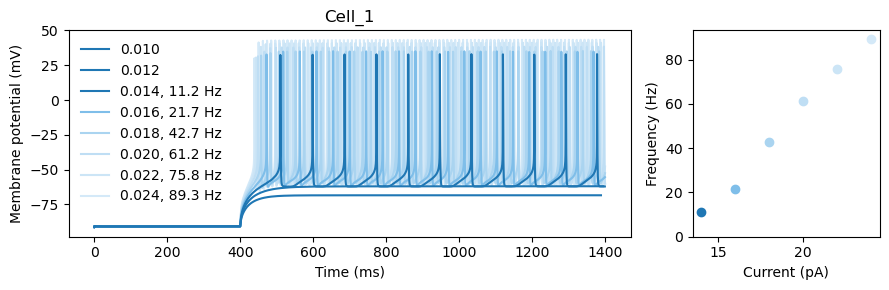

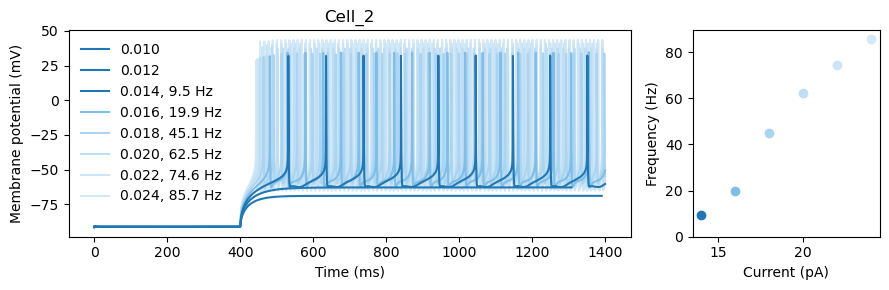

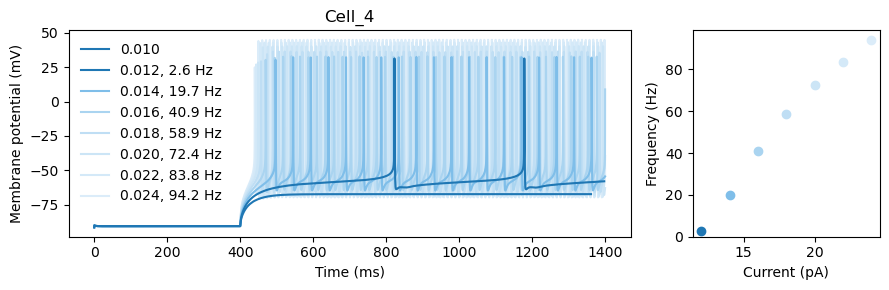

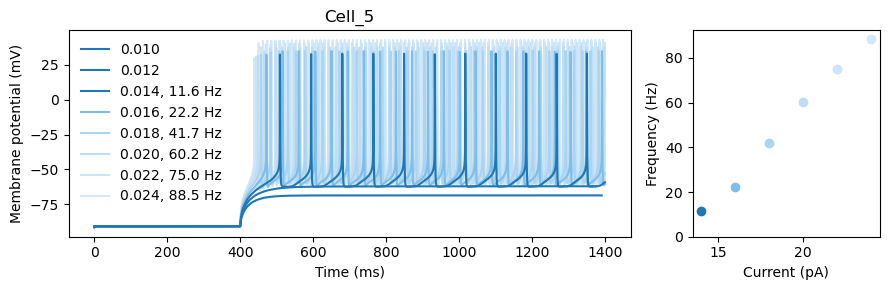

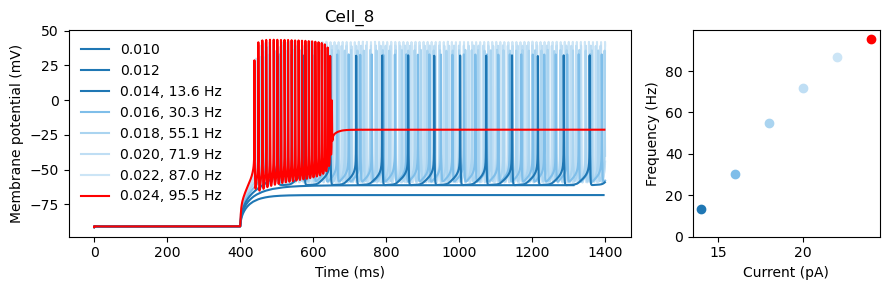

In [12]:
for hoc in cellhocs:
    name = hoc.split('.')[0]
    sweeps = run_model(hoc, amps)
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(9, 3), gridspec_kw={'width_ratios': [3, 1]})
    ax.set_title(name)
    nshade = 0
    nblock = 0
    zorder = 100
    depth = 0
    for sweep in sweeps:
        trace = {}
        trace['T'] = sweep['time']
        trace['V'] = sweep['volt']
        trace['stim_start'] = [stim_start]
        trace['stim_end'] = [stim_end]
        sp = efel.getFeatureValues([trace], ['Spikecount'])[0]
        rate = ''
        depblock = False
        nspikes = sp['Spikecount'][0]
        if nspikes:
            feature_values = efel.getFeatureValues([trace], ['mean_frequency'])[0]
            rate = f", {feature_values['mean_frequency'][0]:.1f} Hz"
            tail = np.array(sweep['volt'][-100:])
            depblock = (np.all(tail > -40) and np.all(tail < 0.0))
        color = 'red' if depblock else 'tab:blue'
        if nspikes:
            color = lighten_color('tab:blue', 1.0 / (nshade + 1))
            depth = 0
        if depblock:
            color = lighten_color('red', 1.0 / (nblock + 1))
            depth = 100
        ax.plot(sweep['time'], sweep['volt'], label=f"{sweep['amp']:0.3f}{rate}", 
                color=color, zorder=zorder + depth)
        if nspikes:
            ax2.plot([sweep['amp']*1e3], feature_values['mean_frequency'], 'o', color=color)
        if depblock:
            nblock += 1
        if nspikes:
            nshade += 1
        zorder -= 1
    ax.legend(frameon=False)
    ax.set_ylabel('Membrane potential (mV)')
    ax.set_xlabel('Time (ms)')
    ax2.set_ylim(bottom=0)
    ax2.set_ylabel('Frequency (Hz)')
    ax2.set_xlabel('Current (pA)')
    fig.tight_layout()

In [13]:
h.load_file(hoc)
name = hoc.split('.')[0]
cmd = 'h.%s("../morphology/")' % name  # default morphology
cell = eval(cmd)

In [14]:
get_terminals(cell.dend[0])

[Cell_8[1].dend[10],
 Cell_8[1].dend[9],
 Cell_8[1].dend[7],
 Cell_8[1].dend[5],
 Cell_8[1].dend[4],
 Cell_8[1].dend[2]]

In [15]:
sec = cell.dend[9]
pse = sec.psection()

In [16]:
pse['cm'], pse['density_mechs']['pas']['g']

([1.0, 1.0, 1.0],
 [1.0285686260089746e-05, 1.0285686260089746e-05, 1.0285686260089746e-05])